# Introduction

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Personalized unction library
from prepare_country_data import transpose_for_country_code, split_and_normalize, cyclical_transformation

# Prepare dataset

In [6]:
# Load complete dataset
df = pd.read_csv("data/2023/nordic_energy_data.csv")
# Apply transformations based on desired bidding zone
df_dk1 = transpose_for_country_code(df, "DK_1")
# Apply cyclical transformation to time
df_dk1 = cyclical_transformation(df_dk1)
# Chose desired time period
df_dk1['Timestamp'] = pd.to_datetime(df_dk1['Timestamp'])
df_dk1 = df_dk1[(df_dk1['Timestamp'].dt.month >= 11) & (df_dk1['Timestamp'].dt.month <= 11)]
# Apply split and normalization based on desired number of test days
X_train, X_test, y_train, y_test, X_train_mean, X_train_std, y_train_mean, y_train_std = split_and_normalize(df_dk1, test_days=2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Convert to numpy arrays - relevant for some models
X_train_num = X_train.to_numpy()
X_test_num = X_test.to_numpy()
y_train_num = y_train.to_numpy()
y_test_num = y_test.to_numpy()

(672, 76) (48, 76) (672,) (48,)


# Temporal Model MMCA

# Temporal Model SVI

# Simple Gaussian Model

In [9]:
# Define Covariance functions
def covSE(x1, x2, cov_params=[2.0]):
    return np.exp(-cov_params[0]*np.sum((x1 - x2)**2))

def covPER(x1, x2, cov_params):
    return cov_params[0] * np.exp(-cov_params[1] * np.sum( np.sin(np.pi*(x1-x2)/cov_params[2])**2 ))

def covWN(x1, x2, cov_params):
    if x1.any() == x2.any():
        return cov_params[0]
    else:
        return 0

def cov(x1, x2, cov_fn, cov_params):
    K = np.zeros((len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i,j] = cov_fn(x1[i,:], x2[j,:], cov_params)
    return K

def covSUM_WN_SE(x1, x2, cov_params):
    K = covWN(x1, x2, cov_params[:1]) + covSE(x1, x2, cov_params[1:])
    return K

def covSUM_PER_SE(x1, x2, cov_params):
    return covPER(x1, x2, cov_params[:3]) + covSE(x1, x2, cov_params[3:])

def make_and_plot_cov(X, cov_func, cov_params):

    # construct K
    K = cov(X, X, cov_func, cov_params)
    plt.imshow(K)
    plt.title("Covariance matrix from Gaussian process prior")
    plt.show()
    return K

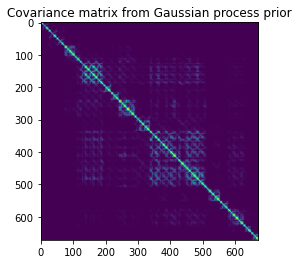

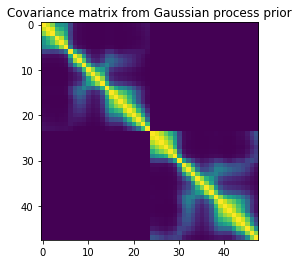

In [10]:
# Plot covariance matrices K and K_star_star
K = make_and_plot_cov(X_train_num, covSE, [0.05])
K = make_and_plot_cov(X_test_num, covSE, [0.1])

In [11]:
# Function to compute the predictive posterior
def compute_predictive_posterior(X_test, sigma, cov_params):
    N_test = len(X_test_num)

    predictions_gp = np.zeros(N_test)
    variances = np.zeros(N_test)
    
    K = cov(X_train_num, X_train_num, covSUM_PER_SE, cov_params)
    k_star = cov(X_train_num, X_test_num, covSUM_PER_SE, cov_params)
    k_star_star = cov(X_test_num, X_test_num, covSUM_PER_SE, cov_params)
    
    mean = k_star.T @ np.linalg.inv(sigma**2*np.eye(X_train_num.shape[0]) + K) @ y_train_num
    std = k_star_star + sigma**2 - k_star.T @ np.linalg.inv(sigma**2 * np.eye(X_train_num.shape[0]) + K) @ k_star

    predictions_gp =  np.random.multivariate_normal(mean.squeeze(), std)

    variances = np.diag(std)
    
    return predictions_gp, variances, mean, std, K

# Define parameters
#cov_params = [1, 0.05, 2, 0.0001] # relatively good for PER_SE
cov_params = [0.0001]
sigma = 0.01
# Run model
predictions_gp, variances, mean, std, K = compute_predictive_posterior(X_test, sigma, cov_params)

Mean squared error: 9.032539539979114
Root mean squared error: 3.0054183635525877
Mean absolute error: 2.532155909104864


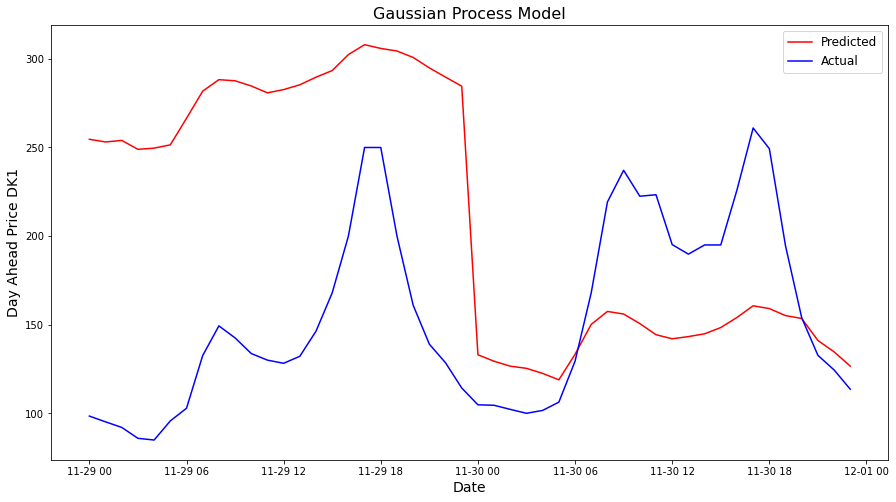

In [12]:
# print error measures
mse = mean_squared_error(y_test_num, predictions_gp)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_num, predictions_gp)
print(f"Mean squared error: {mse}")
print(f"Root mean squared error: {rmse}")
print(f"Mean absolute error: {mae}")

# Plot results
plt.figure(figsize=(15, 8))
predictions_gp_std = (predictions_gp * y_train_std) + y_train_mean
y_test_num_std = (y_test_num * y_train_std) + y_train_mean

plt.plot(y_test.index, predictions_gp_std, label="Predicted", color="red")
plt.plot(y_test.index, y_test_num_std, label="Actual", color="blue")
plt.xlabel("Date", fontsize=14)
plt.ylabel("Day Ahead Price DK1", fontsize=14)
plt.title("Gaussian Process Model", fontsize=16)
plt.legend(fontsize=12)
plt.show()

# PPCA